In [28]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.metrics import accuracy_score
np.set_printoptions(precision=5)#show 5 number after decimal point 

In [29]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [30]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [31]:
print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (60000, 28, 28)
y_train.shape : (60000,)
X_test.shape : (10000, 28, 28)
y_test.shape : (10000,)


In [32]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [33]:
X_train = X_train.reshape(60000,28*28)
X_test = X_test.reshape(10000, 28*28)

y_train = y_train.reshape(60000,1)
y_test = y_test.reshape(10000,1)

In [34]:
print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (60000, 784)
y_train.shape : (60000,)
X_test.shape : (10000, 784)
y_test.shape : (10000,)


In [35]:
#Check that we have balnced data
unique, counts = np.unique(y_train, return_counts=True)
print("y_train :", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("y_test :", dict(zip(unique, counts)))

y_train : {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
y_test : {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


##  Models:

We will try several models and in the end we will decide which is the best model.<br>
We will try the following models:
* Random Forest
* KNN

In [36]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print("The DummyClassifier score is:" ,accuracy_score(y_pred,y_test))

The DummyClassifier score is: 0.1


In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [38]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier().fit(X_train, y_train)
y_pred = KNN.predict(X_test)
precision = metrics.precision_score(y_test, y_pred, average="weighted")          
accuracy = metrics.accuracy_score(y_test, y_pred)
print("precision_score:", precision)
print("Accuracy:", accuracy)
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

precision_score: 0.8578152450755355
Accuracy: 0.8554
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.73      0.82      0.77      1000
           3       0.90      0.86      0.88      1000
           4       0.79      0.77      0.78      1000
           5       0.99      0.82      0.90      1000
           6       0.66      0.57      0.61      1000
           7       0.88      0.96      0.92      1000
           8       0.97      0.95      0.96      1000
           9       0.90      0.97      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



KNN 

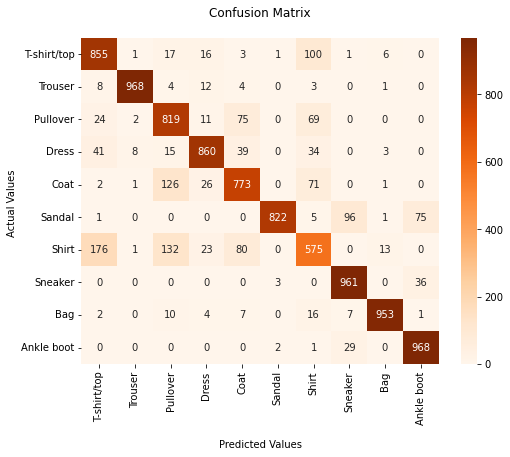

In [39]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Oranges')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],rotation=90)
ax.yaxis.set_ticklabels(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],rotation=0)

plt.show()

In [41]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = RF.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.8764
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.81      0.79      1000
           3       0.88      0.90      0.89      1000
           4       0.77      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.58      0.64      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



In [ ]:
%%time
from xgboost import XGBClassifier

XGB = XGBClassifier(objective="multi:softprob").fit(X_train, y_train)
y_pred = XGB.predict(X_test)

precision = metrics.precision_score(y_test, y_pred, average="weighted")          
accuracy = metrics.accuracy_score(y_test, y_pred)
print("precision_score:", precision)
print("Accuracy:", accuracy)
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

In [ ]:
#Searching for better performance out of the models with RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV